table of contents
1. Prepare
2. Data Import, Encoding
3. Join Data
3. Analyze

# Prepare

## Import Library

In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.append('../')
import pandas as pd

import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.vaep as vaep

## Setting Parameters

In [2]:
## Configure file and folder names
datafolder = "../data"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"predictions.h5")
statsbomb_h5 = os.path.join(datafolder,"statsbomb.h5")

## Import Data

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "FIFA World Cup"]
print("nb of games:", len(games))

nb of games: 64


In [84]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .merge(players,"left",on="player_id")
        .merge(teams,"left",on="team_id")
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5,f"game_{game.game_id}")
    values = vaep.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)
A.columns

100%|██████████| 64/64 [00:06<00:00,  9.54it/s]


Index(['game_id', 'period_id', 'time_seconds', 'timestamp', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'type_name', 'result_name', 'bodypart_name',
       'player_name', 'player_nickname', 'jersey_number', 'country_id',
       'country_name', 'extra', 'team_name', 'scores', 'concedes',
       'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

## add columns play_pattern_name to A

In [85]:
df_list = []
mst_df = pd.read_hdf(spadl_h5,f"actiontypes")
for match_id in tqdm.tqdm(games.match_id.tolist()):
    df_tmp = pd.read_hdf(statsbomb_h5,f"events/match_{match_id}")
    df_tmp = df_tmp.rename(columns={'period': 'period_id', 'match_id': 'game_id'})
    
    df = pd.merge(A[A.game_id==match_id], df_tmp[['game_id', 'period_id', 'timestamp', 'player_id', 'position_name', 'play_pattern_name']], on=['game_id', 'period_id', 'timestamp', 'player_id'], how='left').drop(columns=['extra']).drop_duplicates()
    df_list.append(df)
    
df = pd.concat(df_list).reset_index(drop=True)

100%|██████████| 64/64 [00:08<00:00,  7.57it/s]


## player_name

In [74]:
# df['player_name'] = df[['player_name', 'player_nickname']].apply(lambda xs: xs[1] if xs[1] else xs[0], axis=1)

## play minutes eaach player

In [86]:
mst_df = pd.read_hdf(spadl_h5,"player_games")

In [87]:
mst_df = mst_df[["player_name","minutes_played"]].groupby("player_name").sum().reset_index()

# EDA

## play_pattern別のもろもろ

Text(0,0.5,'')

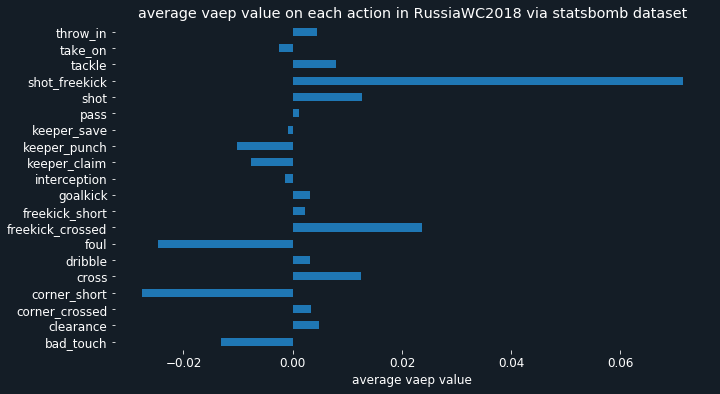

In [6]:
twitter_color = '#141d26'

plt.rcParams["font.size"] = 12
# 文字カラーを白に
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = plt.rcParams['ytick.color'] = COLOR

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16/1.5, 9/1.5))

ax.spines['bottom'].set_color(None); ax.spines['left'].set_color(None); ax.spines['right'].set_color(None); ax.spines['top'].set_color(None)
fig.patch.set_facecolor(twitter_color)
ax.patch.set_facecolor(twitter_color)

df[df.type_name!='shot_penalty'].groupby('type_name')['vaep_value'].mean().plot.barh(ax=ax)
ax.set_title('average vaep value on each action in RussiaWC2018 via statsbomb dataset'); ax.set_xlabel('average vaep value'); ax.set_ylabel('')
# df[df.type_name!='shot_penalty'].groupby('type_name').size().plot.barh(ax=axes[1])

# position別の分析

In [7]:
position_name_list_dict = {
    'Goalkeeper':['Goalkeeper'],
    'Center Back':['Center Back', 'Right Center Back', 'Left Center Back'],
    'Side, Wing Back':['Right Back', 'Left Back', 'Right Wing Back', 'Left Wing Back'],
    'Defensive Midfield':['Left Defensive Midfield', 'Center Defensive Midfield', 'Right Defensive Midfield'],
    'Center Midfield':['Left Center Midfield','Center Midfield','Right Center Midfield'],
    'Attacking Midfield':['Left Attacking Midfield', 'Center Attacking Midfield', 'Right Attacking Midfield'],
    'Side Half, Wing':['Left Midfield', 'Right Midfield', 'Left Wing', 'Right Wing'],
    'Forward':['Secondary Striker', 'Left Center Forward', 'Center Forward', 'Right Center Forward']
}

In [58]:
## 汎用関数の定義
def aggregate_df_by_type_name(df, position_name, mst_df, type_name_list_dict, N=10):
    print(position_name)
    print('total')
    stats_tmp = pd.merge(df[df.position_name.isin(position_name_list_dict[position_name])].groupby(['player_name','country_name']).vaep_value.sum().reset_index(), mst_df[mst_df.minutes_played>=150], on='player_name', how='inner')
    stats_tmp['sum_vaep_per_game'] = stats_tmp.vaep_value / stats_tmp.minutes_played * 90
    display(stats_tmp.sort_values('sum_vaep_per_game', ascending=False).head(N))
    for k, v_list in type_name_list_dict.items():
        df_tmp = df[(df.position_name.isin(position_name_list_dict[position_name]))&(df.type_name.isin(v_list))] 
        stats_tmp = pd.merge(df_tmp.groupby(['player_name','country_name']).vaep_value.sum().reset_index(), mst_df[mst_df.minutes_played>=150], on='player_name', how='inner')
        stats_tmp['sum_vaep_per_game'] = stats_tmp.vaep_value / stats_tmp.minutes_played * 90
        print(k)
        display(stats_tmp.sort_values('sum_vaep_per_game', ascending=False).head(N))

## GK

In [59]:
df[df.position_name.isin(position_name_list_dict['Goalkeeper'])].head()

,game_id,period_id,time_seconds,timestamp,team_id,player_id,start_x,start_y,end_x,end_y,...,country_id,country_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value,position_name,play_pattern_name
65,8655,1,113.0,00:01:53.799,771,3099,6.176471,25.822785,11.470588,32.708861,...,78.0,France,France,0.003924,0.002988,0.001702,0.002085,0.003787,Goalkeeper,From Throw In
66,8655,1,118.0,00:01:58.360,771,3099,11.470588,32.708861,18.529412,14.632911,...,78.0,France,France,0.003358,0.003266,-0.000566,-0.000278,-0.000844,Goalkeeper,From Throw In
166,8655,1,398.0,00:06:38.680,771,3099,5.294118,31.848101,67.941176,32.708861,...,78.0,France,France,0.005424,0.003554,0.005424,-0.003554,0.001869,Goalkeeper,From Goal Kick
247,8655,1,567.0,00:09:27.640,771,3099,7.058824,40.455696,8.823529,37.873418,...,78.0,France,France,0.003703,0.002597,0.001074,0.000827,0.001901,Goalkeeper,Regular Play
248,8655,1,569.0,00:09:29.200,771,3099,8.823529,37.873418,15.000000,12.050633,...,78.0,France,France,0.003358,0.002711,-0.000345,-0.000114,-0.000459,Goalkeeper,Regular Play


In [95]:
df[df.player_name.str.contains('Navas')].player_name.unique()

array(['Keylor Navas Gamboa'], dtype=object)

In [98]:
pd.merge(df.groupby('player_name').vaep_value.sum(), mst_df[mst_df.player_name.str.contains('Navas')], on=['player_name'])

,player_name,vaep_value,minutes_played
0,Keylor Navas Gamboa,0.769388,658


In [60]:
df[df.position_name.isin(position_name_list_dict['Goalkeeper'])].type_name.unique()

array(['dribble', 'pass', 'goalkick', 'keeper_save', 'keeper_punch',
       'freekick_crossed', 'freekick_short', 'keeper_claim', 'foul',
       'clearance', 'take_on', 'shot', 'throw_in'], dtype=object)

In [61]:
type_name_list_dict = {
    'defensive' : ['keeper_save', 'keeper_punch', 'keepre_claim','foul'],
    'offensive' : ['dribble', 'pass', 'goalkick','freekick_crossed','freekick_short','clearance','take_on','shot','throw_in']
}

In [96]:
aggregate_df_by_type_name(df, 'Goalkeeper', mst_df, type_name_list_dict, 15)

Goalkeeper
total


,player_name,country_name,vaep_value,minutes_played,sum_vaep_per_game
24,Pedro David Gallese Quiróz,Peru,0.969695,283,0.308384
20,Mathew Ryan,Australia,0.556677,282,0.177663
16,Kasper Schmeichel,Denmark,0.793327,409,0.174571
11,Hugo Lloris,France,1.066844,569,0.168745
14,Jaime Manuel Penedo Cano,Panama,0.522665,285,0.165052
19,Manuel Neuer,Germany,0.486153,289,0.151397
25,Robin Olsen,Sweden,0.799440,476,0.151155
6,Farouk Ben Mustapha,Tunisia,0.284042,173,0.147768
23,Néstor Fernando Muslera Micol,Uruguay,0.768262,473,0.146181
15,Jordan Pickford,England,0.980937,720,0.122617


defensive


,player_name,country_name,vaep_value,minutes_played,sum_vaep_per_game
24,Pedro David Gallese Quiróz,Peru,0.404984,283,0.128793
20,Mathew Ryan,Australia,0.113884,282,0.036346
19,Manuel Neuer,Germany,0.104062,289,0.032407
11,Hugo Lloris,France,0.176889,569,0.027979
9,Franco Armani,Argentina,0.051920,189,0.024724
16,Kasper Schmeichel,Denmark,0.093282,409,0.020527
10,Hannes Þór Halldórsson,Iceland,0.061834,285,0.019527
0,Alireza Safar Beiranvand,"Iran, Islamic Republic of",0.050030,287,0.015689
18,Khadim N'Diaye,Senegal,0.046053,281,0.014750
2,Danijel Subašić,Croatia,0.106806,663,0.014498


offensive


,player_name,country_name,vaep_value,minutes_played,sum_vaep_per_game
14,Jaime Manuel Penedo Cano,Panama,0.639070,285,0.201812
24,Pedro David Gallese Quiróz,Peru,0.616326,283,0.196005
6,Farouk Ben Mustapha,Tunisia,0.317672,173,0.165263
11,Hugo Lloris,France,1.017185,569,0.160890
25,Robin Olsen,Sweden,0.849929,476,0.160701
13,Igor Akinfeev,Russia,0.938678,535,0.157908
16,Kasper Schmeichel,Denmark,0.696877,409,0.153347
23,Néstor Fernando Muslera Micol,Uruguay,0.796623,473,0.151577
5,Eiji Kawashima,Japan,0.630705,377,0.150566
20,Mathew Ryan,Australia,0.468439,282,0.149502


## CB

In [42]:
df[df.position_name.isin(position_name_list_dict['Center Back'])].head()

,game_id,period_id,time_seconds,timestamp,team_id,player_id,start_x,start_y,end_x,end_y,...,country_id,country_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value,position_name,play_pattern_name
1,8655,1,2.0,00:00:02.220,771,5485,30.000000,28.405063,32.647059,25.822785,...,78.0,France,France,0.004340,0.001063,0.001764,0.000735,0.002499,Right Center Back,From Kick Off
2,8655,1,4.0,00:00:04.160,771,5485,32.647059,25.822785,41.470588,6.886076,...,78.0,France,France,0.004020,0.000827,-0.000320,0.000236,-0.000085,Right Center Back,From Kick Off
10,8655,1,14.0,00:00:14.960,782,20005,94.411765,25.822785,94.411765,25.822785,...,22.0,Belgium,Belgium,0.003017,0.009051,0.002000,0.089236,0.091236,Right Center Back,From Kick Off
24,8655,1,38.0,00:00:38.320,771,5485,41.470588,4.303797,42.352941,9.468354,...,78.0,France,France,0.003328,0.000816,0.001631,0.000433,0.002064,Right Center Back,From Throw In
25,8655,1,39.0,00:00:39.720,771,5485,42.352941,9.468354,39.705882,35.291139,...,78.0,France,France,0.002534,0.001994,-0.000794,-0.001178,-0.001972,Right Center Back,From Throw In


In [55]:
df[df.position_name.isin(position_name_list_dict['Center Back'])].type_name.unique()

array(['dribble', 'pass', 'tackle', 'clearance', 'freekick_short', 'shot',
       'foul', 'interception', 'freekick_crossed', 'throw_in', 'cross',
       'bad_touch', 'take_on', 'shot_freekick', 'shot_penalty',
       'goalkick'], dtype=object)

In [56]:
type_name_list_dict = {
    'defensive' : ['interception','tackle'],
    'offensive' : ['dribble', 'pass', 'goalkick','freekick_crossed','freekick_short','clearance','take_on','shot','throw_in','cross','shot_penalty','bad_touch','shot_freekick']
}

In [57]:
aggregate_df_by_type_name(df, 'Center Back', mst_df, type_name_list_dict)

Center Back
defensive


,player_name,country_name,vaep_value,minutes_played,sum_vaep_per_game
20,Hugo Ayala Castro,Mexico,0.218151,189,0.103881
52,Ragnar Sigurðsson,Iceland,0.240294,228,0.094853
42,Mats Hummels,Germany,0.193582,192,0.090742
14,Fidel Escobar Mendieta,Panama,0.249329,285,0.078735
11,Duško Tošić,Serbia,0.150478,192,0.070536
67,Vincent Kompany,Belgium,0.250931,398,0.056743
54,Romain Saïss,Morocco,0.116943,192,0.054817
2,Andreas Christensen,Denmark,0.174426,311,0.050477
50,Osama Abdulrezag Hawsawi,Saudi Arabia,0.123532,283,0.039286
36,Kári Árnason,Iceland,0.074862,191,0.035275


offensive


,player_name,country_name,vaep_value,minutes_played,sum_vaep_per_game
78,Yerry Fernando Mina González,Colombia,2.553309,315,0.729517
37,Jérôme Boateng,Germany,1.153203,190,0.546254
29,Jan Bednarek,Poland,1.302011,237,0.494435
79,Young-Gwon Kim,Korea (South),1.284384,288,0.401370
31,John Stones,England,2.885288,672,0.386422
48,Mathias Jattah-Njie Jørgensen,Denmark,0.992511,236,0.378500
82,Łukasz Piszczek,Poland,0.614721,177,0.312570
64,Samuel Yves Umtiti,France,1.886980,569,0.298468
23,Harry Maguire,England,2.095496,675,0.279399
15,Faustino Marcos Alberto Rojo,Argentina,0.711015,234,0.273467


## DH

In [48]:
df[df.position_name.isin(position_name_list_dict['Defensive Midfield'])].type_name.unique()

array(['pass', 'dribble', 'tackle', 'take_on', 'interception',
       'freekick_short', 'foul', 'clearance', 'shot', 'cross',
       'freekick_crossed', 'bad_touch', 'corner_short', 'throw_in',
       'shot_freekick', 'corner_crossed', 'shot_penalty'], dtype=object)

In [18]:
type_name_list_dict = {
    'defensive' : ['interception','tackle'],
    'offensive' : ['dribble', 'pass', 'goalkick','freekick_crossed','freekick_short','clearance','take_on','shot','throw_in','cross','shot_penalty','bad_touch','shot_freekick']
}

In [49]:
aggregate_df_by_type_name(df, 'Defensive Midfield', mst_df, type_name_list_dict)

Defensive Midfield
defensive


,player_name,country_name,vaep_value,minutes_played,sum_vaep_per_game
11,Emil Hallfreðsson,Iceland,0.091508,189,0.043575
24,Jacek Góralski,Poland,0.088831,188,0.042525
4,Aron Einar Gunnarsson,Iceland,0.093415,255,0.032970
8,Cheikhou Kouyaté,Senegal,0.041209,131,0.028311
7,Carlos Henrique Casimiro,Brazil,0.136068,438,0.027959
58,Sung-Yeung Ki,Korea (South),0.051327,189,0.024441
10,Ellyes Skhiri,Tunisia,0.066435,284,0.021053
49,Pedro Jesús Aquino Sánchez,Peru,0.033159,152,0.019633
9,Daler Kuzyaev,Russia,0.067162,325,0.018599
48,Paul Pogba,France,0.111508,563,0.017825


offensive


,player_name,country_name,vaep_value,minutes_played,sum_vaep_per_game
49,Milan Badelj,Croatia,1.221503,122,0.901108
55,Paul Pogba,France,1.797041,563,0.287271
7,Aron Einar Gunnarsson,Iceland,0.769572,255,0.271614
22,Gabriel Enrique Gómez Girón,Panama,0.685081,259,0.238059
0,Abdullah Ibrahim Otayf,Saudi Arabia,0.568584,252,0.203066
2,Adrien Sebastian Perruchet Silva,Portugal,0.353583,168,0.189419
40,Lucas Torreira Di Pascua,Uruguay,0.619437,329,0.169451
25,Grzegorz Krychowiak,Poland,0.784305,467,0.151151
72,Víctor Yoshimar Yotún Flores,Peru,0.301421,185,0.146637
61,Saeid Ezatolahi Afagh,"Iran, Islamic Republic of",0.243358,169,0.129599
